# This notebook is for developing plotting functions

In [22]:
import pandas as pd
import pandas as pd
import numpy as np
import obspy

from obspy.clients.fdsn import Client
from obspy import Stream,UTCDateTime
from pnwstore.mseed import WaveformClient
from tqdm import tqdm
from matplotlib.backends.backend_pdf import PdfPages
from obspy.geodetics import locations2degrees, degrees2kilometers
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap

from obspy.clients.fdsn import Client as FDSNClient




In [4]:
def subplots_cluster_scale(mycatalog, mycatalog_picks, networks, channel, idx_sta, fig_title, file_title):
    """
    idx: event_idx
    mycatalog: dataframe that contains only the unique picks (i.e., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    networks: string of networks (e.g., "NV,OO,7A")
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    idx_sta: choose the station to which you want to show the waveforms
    fig_title: title in a string
    file_title: file title in a string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')


    # Plot the earthquake moveout for one of the unmatched events for all stations 
    events = mycatalog
    picks = mycatalog_picks
    events['datetime'] = pd.to_datetime(events['datetime'], utc = True)
    p = PdfPages(file_title) 
    
    for idx in tqdm(events['idx'],total=len(events['idx'])):
        
        picks_idx = picks.loc[picks['idx']==idx]
        pick_sta = np.unique(picks_idx['station'])

        otime = UTCDateTime(str(events[events['idx'] == idx]["datetime"].values[0]))
        distances = []
        max_dist = 10
        min_dist = 0

        print(events[events['idx'] == idx]['picks'].values[0])
        for station in pick_sta:


            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8,level="response")
            if len(sta_inv) == 0:
    #             print(f"Failed to fetch for {networks} {station} {otime}")
                continue

            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = events.loc[events['idx']==idx, 'latitude'].values[0]
            olon = events.loc[events['idx']==idx, 'longitude'].values[0]

            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)
    #         if max_dist < dist:
    #             max_dist = dist

    #         if min_dist > dist:
    #             min_dist = dist

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])
        distances = distances[:idx_sta+1]

        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        # This count is for the if statements. Only used to ensure that min_y_count 
        #is changed from 0 to either the first positive value of the distance of one of the stations from the event
        min_y_count = 0 

        max_x = 0
        min_x = 0

        # This count is for the if statements. Only used to ensure that min_x_count 
        #is changed from 0 to either the first positive value of P pick time or the first positive value of S pick time
        min_x_count= 0
        # Create a figure
        fig,axs = plt.subplots(1,4,figsize=(18,6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
    #     axs = gs.subplots(sharex=True, sharey=True)
        starttime = otime -30
        endtime = otime + 120

        # Define texts
        texts = []

        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                # Query waveforms
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)

            else: 
                st =  Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

    #         print(f"len(st):{len(st)}")
    #         print(st)

            # Skip empty traces
            if len(st) == 0:
                    continue

            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
    #         print(len(p_picks),len(s_picks))

            # Define the xlim values
            # Define the maximum x value
            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            # Define the minimum x value
            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

    #         if len(p_picks) == 0:
    #             continue

    #         print('This is after the p_pick continue statement')

            # Define ylim values
            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2)*(max_y-min_y)   

        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                # Query waveforms
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)

            else: 
                st =  Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

    #         print(f"len(st):{len(st)}")
    #         print(st)

            # Skip empty traces
            if len(st) == 0:
                    continue
            _st = Stream()
            # Check for HH and BH channels presence
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            # Apply selection logic based on channel presence
            if has_HH and has_BH:
                # If both HH and BH channels are present, select only HH
                _st += st.select(channel="HH?")
            elif has_HH:
                # If only HH channels are present
                _st += st.select(channel="HH?")
            elif has_BH:
                # If only BH channels are present
                _st += st.select(channel="BH?")

            st = _st

            print(f'Second st print:{_st}')

            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate') # fill gaps if there are any.

    #         print(st)
            # Select only one trace per channel
            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
    #         print(len(p_picks),len(s_picks))




    #         if len(p_picks) == 0:
    #             continue 
    #         print('This is after the p_pick continue statement')
            print(trim_st)

            for iax in range(len(trim_st)):
                print(iax)
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()

                if len(p_picks)>0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5)*sampling_rate)
                    i2 = int((tp+15)*sampling_rate)
                elif len(s_picks)>0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10)*sampling_rate)
                    i2 = int((ts+10)*sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

                offsets1 = ii[3]
                try: 
                    wave = trim_st[iax].data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1)*10)
                except:
                    continue 

    #             print(trim_st[iax].stats.sampling_rate)
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)
    #             axs[iax].plot(trim_st[iax].times(), wave * 30 + offsets1, color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)

    #             axs[iax].text(xlim[-1] + 2,   offsets1, 
    #                               [ii[2]], fontsize=8, verticalalignment='bottom')

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')
            texts.append([ii[2],ii[3]])


    #     print(max_y,min_y)
        chs = ['2','1','Z']
        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                                      [ii[0]], fontsize=8, verticalalignment='bottom')
            axs[iax].legend(chs[iax],loc='upper right', handlelength=0)
            axs[iax].set_ylim([min_y,max_y])
            axs[iax].set_xlim([min_x,max_x])
            axs[iax].grid(alpha=0.5)
        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{title}: Origin Time={otime}, \n Latitude={round(events[events['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(events[events['idx']==idx]['longitude'].values[0], 2)}, Depth={round(events[events['idx']==idx]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(40, 51, 1), labels=[1,0,0,0])
        m.drawmeridians(np.arange(-130, -119, 1), labels=[0,0,0,1])
        x, y = m(events[events['idx']==idx]['longitude'].values[0], events[events['idx']==idx]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close() 

In [8]:
mycatalog_picks

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,2109680,-0.530608,FN07A,P,1.312886e+09
1,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,4141442,-0.160235,FN07A,S,1.312886e+09
2,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,1939147,-0.348758,FN14A,P,1.312886e+09
3,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,3969523,0.828527,FN14A,S,1.312886e+09
4,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,2130175,0.505961,J49A,P,1.312886e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100519,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,3095737,-0.039125,FN12C,S,1.403969e+09
100520,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,1037760,1.222291,J49C,P,1.403969e+09
100521,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,3089858,-0.647115,J49C,S,1.403969e+09
100522,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,1375420,-1.186613,J57C,P,1.403969e+09


In [38]:
year = 'pnsn_wa'
mycatalog = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/new_events_filtered_{year}.csv',index_col=0)
mycatalog_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_pick_assignments_{year}.csv',index_col=0)
all_picks = pd.read_csv(f'/home/hbito/cascadia_obs_ensemble/data/datasets_{year}/all_picks_all_years_for_assoc_{year}.csv',index_col=0)

 80%|████████  | 4/5 [00:23<00:05,  5.61s/it]/tmp/ipykernel_1997581/713922907.py:278: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axs[iax].set_ylim([min_y,max_y])
/tmp/ipykernel_1997581/713922907.py:279: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  axs[iax].set_xlim([min_x,max_x])
100%|██████████| 5/5 [00:26<00:00,  5.38s/it]


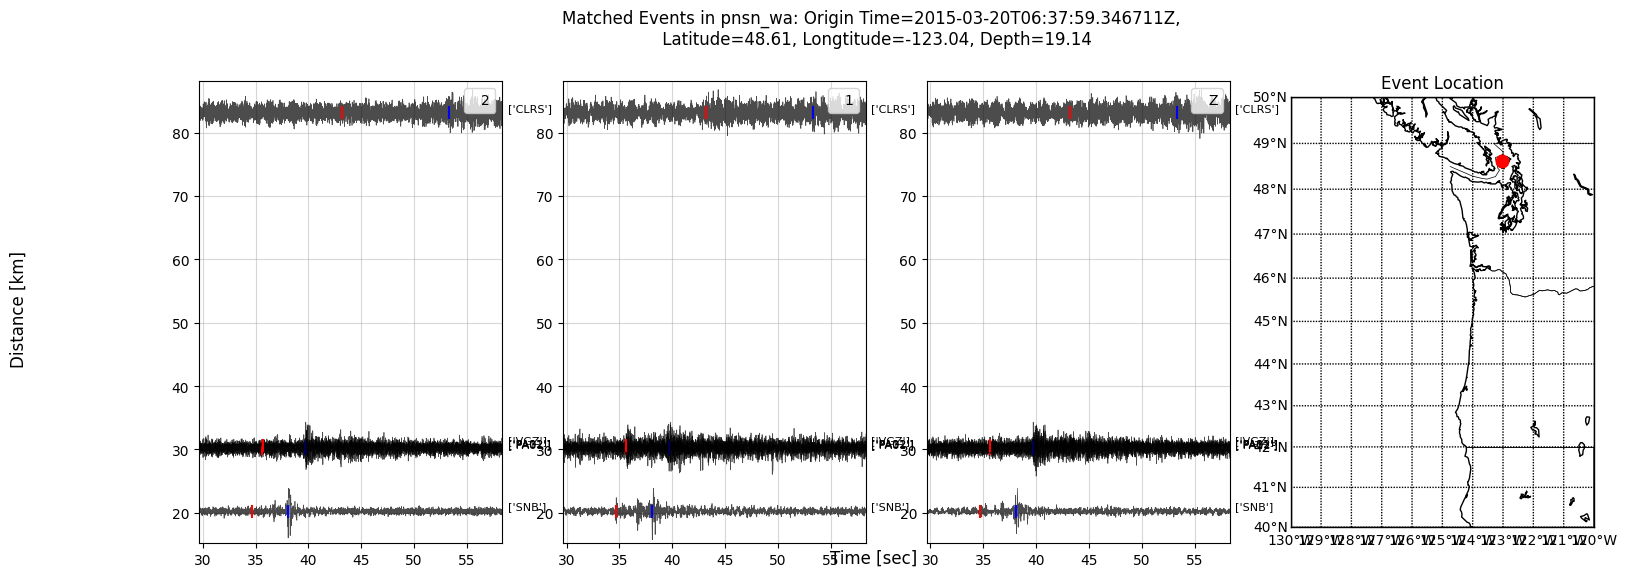

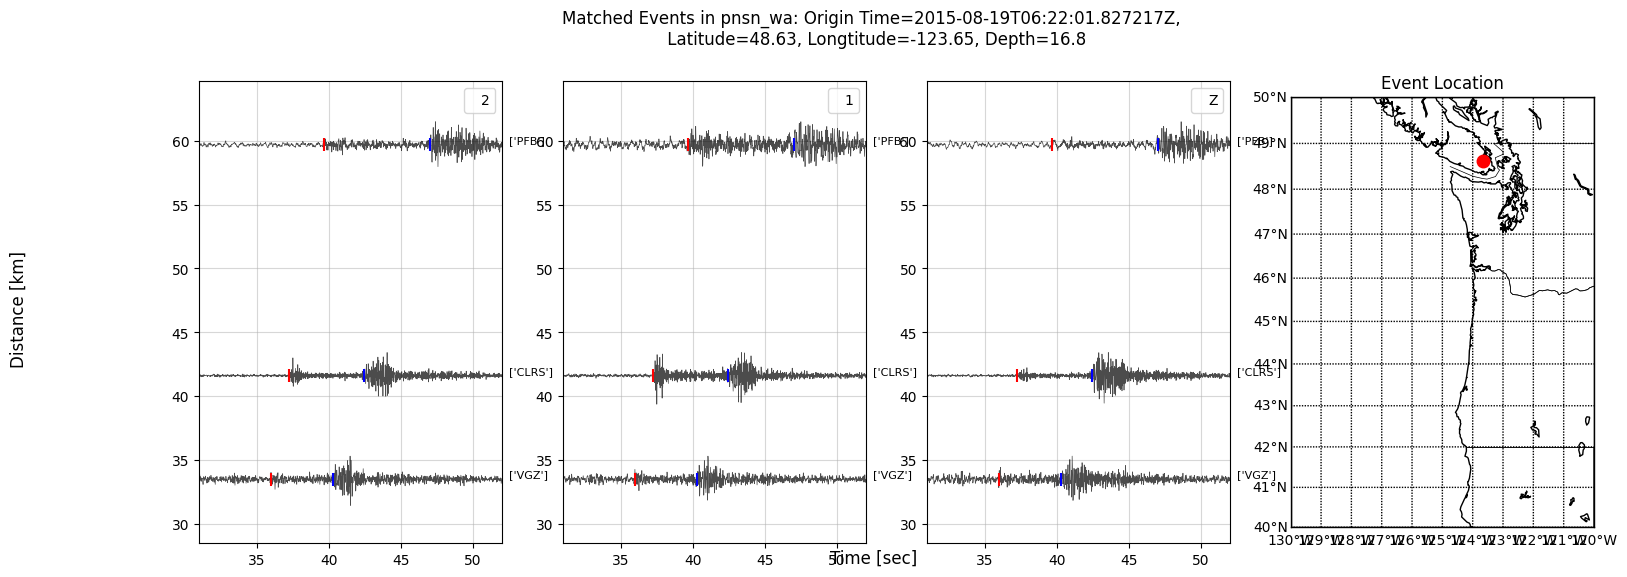

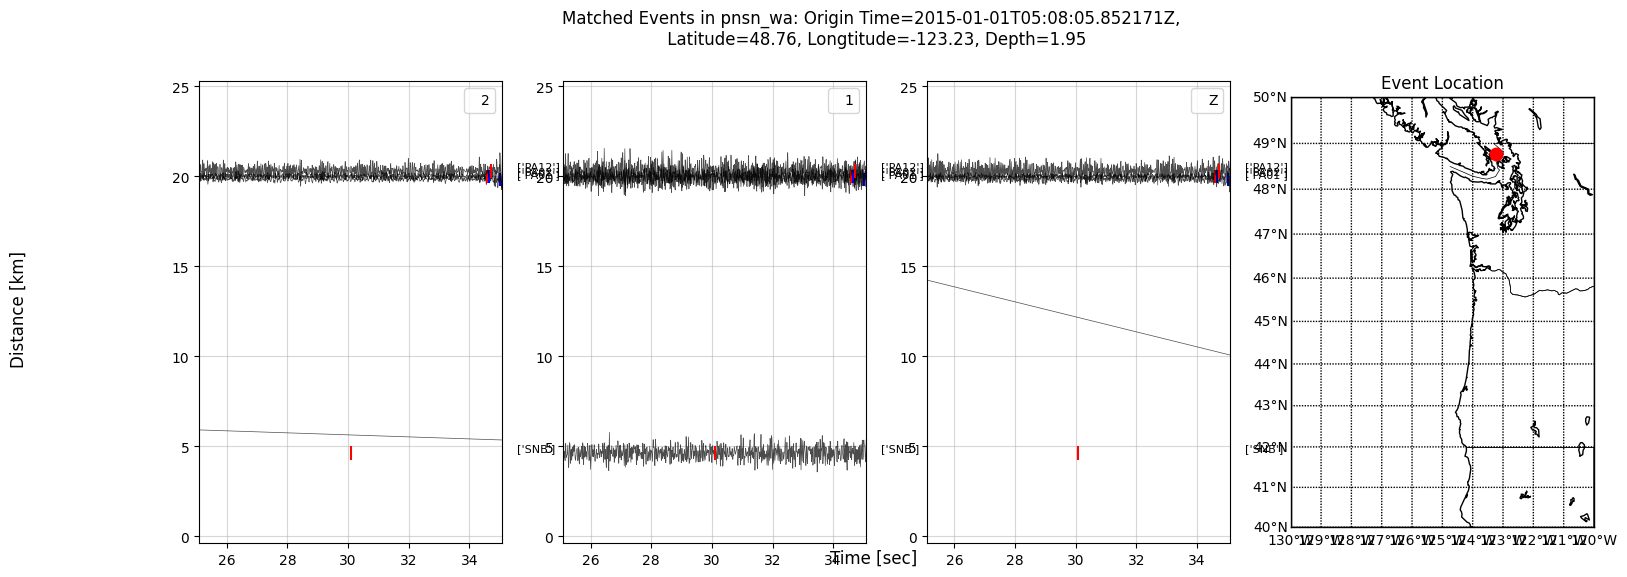

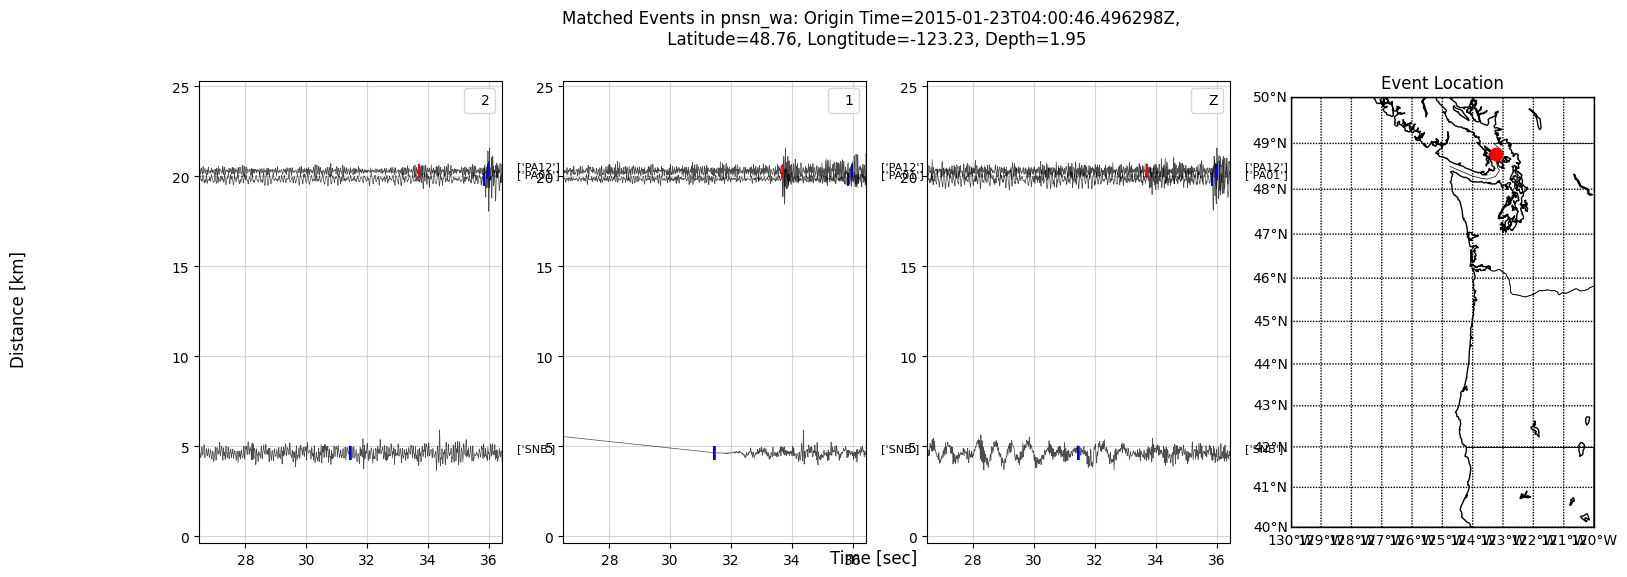

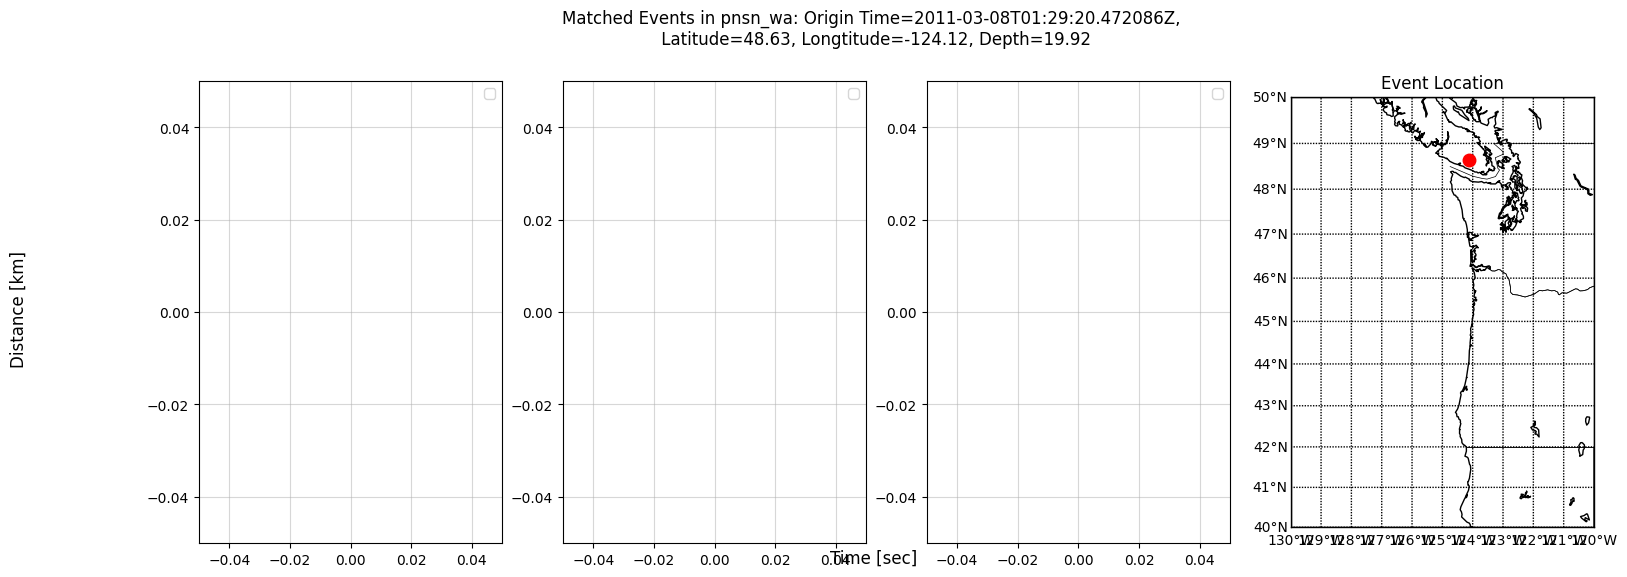

In [39]:
subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, 'HH?', f'Matched Events in {year}', f'{year}.pdf')

In [28]:

def subplots_cluster_scale_rand(mycatalog, mycatalog_picks, all_picks, channel, fig_title, file_title):
    """
    mycatalog: dataframe that contains only the unique events (e.g., mycatalog_picks.drop_duplicates(subset=['idx']).copy())
    mycatalog_picks: all pick assignments csv file (e.g., pd.read_csv('../data/datasets_OR/all_pick_assignments_OR.csv'))
    all_picks: all_picks csv file (e.g., pd.read_csv('../data/datasets_OR_010/all_picks_OR'))
    channel: specify the direction of the channel (i.e., "?HZ", "?HE" or "?HN")
    fig_title: title in a string
    file_title: file title in a string
    """
        
    # Define the clients 
    client_waveform = WaveformClient()
    client2 = Client("IRIS")
    client_ncedc = Client('NCEDC')

    # Plot the earthquake moveout for one of the unmatched events for all stations 
    events = mycatalog
    picks = mycatalog_picks
    events['datetime'] = pd.to_datetime(events['time'], utc=True)

    networks = all_picks['station_network_code'].drop_duplicates()
    networks = ','.join(networks)

    p = PdfPages(file_title) 
    
    # Randomly select 5 events
    random_events = events.sample(n=5, random_state=42)
    
    for idx in tqdm(random_events['idx'], total=len(random_events['idx'])):
        
        picks_idx = picks.loc[picks['idx'] == idx]
        pick_sta = np.unique(picks_idx['station'])

        otime = UTCDateTime(str(events[events['idx'] == idx]["datetime"].values[0]))
        distances = []
        max_dist = 10
        min_dist = 0

        for station in pick_sta:
            sta_inv = client2.get_stations(network=networks,
                                           station=station, channel="?H?", 
                                           starttime=otime - 1e8, endtime=otime + 1e8, level="response")
            if len(sta_inv) == 0:
                continue
            
            _network = sta_inv[0].code
            slat = sta_inv[0][0].latitude
            slon = sta_inv[0][0].longitude
            olat = events.loc[events['idx']==idx, 'latitude'].values[0]
            olon = events.loc[events['idx']==idx, 'longitude'].values[0]

            dis1 = locations2degrees(olat, olon, slat, slon)
            dist = degrees2kilometers(dis1)
    #         if max_dist < dist:
    #             max_dist = dist

    #         if min_dist > dist:
    #             min_dist = dist

            distances.append([None, _network, station, dist])

        # Sort distances
        distances = sorted(distances, key=lambda item: item[-1])

        # Set up to define the xlim and ylim
        max_y = 0
        min_y = 0
        # This count is for the if statements. Only used to ensure that min_y_count 
        #is changed from 0 to either the first positive value of the distance of one of the stations from the event
        min_y_count = 0 

        max_x = 0
        min_x = 0

        # This count is for the if statements. Only used to ensure that min_x_count 
        #is changed from 0 to either the first positive value of P pick time or the first positive value of S pick time
        min_x_count= 0
        # Create a figure
        fig,axs = plt.subplots(1,4,figsize=(18,6))
        gs = fig.add_gridspec(3, hspace=0, figure=fig)
    #     axs = gs.subplots(sharex=True, sharey=True)
        starttime = otime -30
        endtime = otime + 120

        # Define texts
        texts = []

        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                # Query waveforms
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)

            else: 
                st =  Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

    #         print(f"len(st):{len(st)}")
    #         print(st)

            # Skip empty traces
            if len(st) == 0:
                    continue

            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
    #         print(len(p_picks),len(s_picks))

            # Define the xlim values
            # Define the maximum x value
            if len(s_picks) > 0:
                if max_x < UTCDateTime(s_picks.iloc[0]['time_pick']) - starttime:
                    max_x = UTCDateTime(s_picks.iloc[0]['time_pick']+5) - starttime
            elif len(p_picks) > 0:
                if max_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime: 
                    max_x = UTCDateTime(p_picks.iloc[0]['time_pick']+5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue 

            # Define the minimum x value
            if len(p_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime
                        min_x_count += 1           
                else:
                    if min_x >= UTCDateTime(p_picks.iloc[0]['time_pick']) - starttime:
                        min_x = UTCDateTime(p_picks.iloc[0]['time_pick']-5) - starttime            
            elif len(s_picks) > 0:
                if min_x_count == 0:
                    if min_x < UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5)- starttime
                        min_x_count += 1                
                else:
                    if min_x >= UTCDateTime(s_picks.iloc[0]['time_pick'])- starttime:
                        min_x = UTCDateTime(s_picks.iloc[0]['time_pick']-5) - starttime
            else:
                print('No picks for this station. Skipping.')
                continue    

    #         if len(p_picks) == 0:
    #             continue

    #         print('This is after the p_pick continue statement')

            # Define ylim values
            if min_y_count == 0:
                if min_y < ii[3]:
                    min_y = ii[3] - 5
                    min_y_count += 1           
            else:
                if min_y >= ii[3]:
                    min_y = ii[3] - 5 

            max_y = ii[3] + 5

        scaling_factor = (1/2)*(max_y-min_y)   

        for i, ii in enumerate(distances):

            if ii[1] in ['NC', 'BK']:
                # Query waveforms
                st = client_ncedc.get_waveforms(network=ii[1], station=ii[2], location="*", channel=channel,starttime=starttime, endtime=endtime)

            elif ii[1] in networks: 
                st = client_waveform.get_waveforms(network=ii[1], station=ii[2], channel=channel,starttime=starttime, endtime=endtime)

            else: 
                st =  Stream()
                print(f"WARNING: No data for {ii[1]}.{ii[2]}.{channel} on {otime}.")    
                continue

    #         print(f"len(st):{len(st)}")
    #         print(st)

            # Skip empty traces
            if len(st) == 0:
                    continue
            _st = Stream()
            # Check for HH and BH channels presence
            has_HH = bool(st.select(channel="HH?"))
            has_BH = bool(st.select(channel="BH?"))

            # Apply selection logic based on channel presence
            if has_HH and has_BH:
                # If both HH and BH channels are present, select only HH
                _st += st.select(channel="HH?")
            elif has_HH:
                # If only HH channels are present
                _st += st.select(channel="HH?")
            elif has_BH:
                # If only BH channels are present
                _st += st.select(channel="BH?")

            st = _st


            st = Stream(filter(lambda st: st.stats.sampling_rate > 10, st))
            st.taper(max_percentage=0.05)
            st.filter(type='bandpass', freqmin=2, freqmax=25)
            st.merge(fill_value='interpolate') # fill gaps if there are any.

    #         print(st)
            # Select only one trace per channel
            unique_channels = set(tr.stats.channel for tr in st)
            selected_traces = []

            for ch in unique_channels:
                selected_traces.append(next(tr for tr in st if tr.stats.channel == ch))
            st = Stream(selected_traces)

            trim_st = st.copy()
            sta_picks = picks_idx[picks_idx['station'] == ii[2]]
            p_picks = sta_picks.loc[sta_picks['phase'] == 'P']
            s_picks = sta_picks.loc[sta_picks['phase'] == 'S']
    #         print(len(p_picks),len(s_picks))




    #         if len(p_picks) == 0:
    #             continue 
    #         print('This is after the p_pick continue statement')

            for iax in range(len(trim_st)):
                sampling_rate = trim_st[iax].stats.sampling_rate
                trim_st = trim_st.normalize()

                if len(p_picks)>0:
                    tp = UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((tp-5)*sampling_rate)
                    i2 = int((tp+15)*sampling_rate)
                elif len(s_picks)>0:
                    ts = UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30
                    i1 = int((ts-10)*sampling_rate)
                    i2 = int((ts+10)*sampling_rate)
                else:
                    print(f"WARNING: No pick time for {ii[1]}.{ii[2]}.{channel} on {otime}.")

                offsets1 = ii[3]
                try: 
                    wave = trim_st[iax].data
                    wave = wave / (np.nanmax(wave[i1:i2], axis=-1)*10)
                except:
                    continue 

    #             print(trim_st[iax].stats.sampling_rate)
                axs[iax].plot(trim_st[iax].times(), wave * scaling_factor + offsets1, 
                              color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)
    #             axs[iax].plot(trim_st[iax].times(), wave * 30 + offsets1, color='black', label=f"{trim_st[iax].stats.channel}", alpha=0.7, lw=0.5)

    #             axs[iax].text(xlim[-1] + 2,   offsets1, 
    #                               [ii[2]], fontsize=8, verticalalignment='bottom')

                if len(p_picks) > 0:
                    axs[iax].vlines(UTCDateTime(p_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='r')
                if len(s_picks) > 0:
                    axs[iax].vlines(UTCDateTime(s_picks.iloc[0]['time_pick']) - otime + 30, offsets1 - (1/35) * scaling_factor, 
                                    offsets1 + (1/35) * scaling_factor, color='b')
            texts.append([ii[2],ii[3]])


    #     print(max_y,min_y)
        chs = ['2','1','Z']
        for iax in range(3):
            for i, ii in enumerate(texts):
                offsets1 = ii[1]
                axs[iax].text(max_x + 0.5, offsets1, 
                                      [ii[0]], fontsize=8, verticalalignment='bottom')
            axs[iax].legend(chs[iax],loc='upper right', handlelength=0)
            axs[iax].set_ylim([min_y,max_y])
            axs[iax].set_xlim([min_x,max_x])
            axs[iax].grid(alpha=0.5)
        fig.supxlabel('Time [sec]', y=0.07)
        fig.supylabel('Distance [km]')
        fig.suptitle(f"{fig_title}: Origin Time={otime}, \n Latitude={round(events[events['idx']==idx]['latitude'].values[0], 2)}, Longtitude={round(events[events['idx']==idx]['longitude'].values[0], 2)}, Depth={round(events[events['idx']==idx]['depth'].values[0], 2)}", y=1)

        m = Basemap(projection='merc', llcrnrlat=40, urcrnrlat=50, llcrnrlon=-130, urcrnrlon=-120, resolution='i', ax=axs[3])
        m.drawcoastlines()
        m.drawcountries()
        m.drawstates()
        m.drawmapboundary()
        m.drawparallels(np.arange(40, 51, 1), labels=[1,0,0,0])
        m.drawmeridians(np.arange(-130, -119, 1), labels=[0,0,0,1])
        x, y = m(events[events['idx']==idx]['longitude'].values[0], events[events['idx']==idx]['latitude'].values[0])
        m.plot(x, y, 'ro', markersize=9)
        axs[3].set_title('Event Location')
        
        fig.savefig(p, format='pdf')  

    p.close() 


